In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [3]:

!conda install -c bioconda blast -y
!makeblastdb -in reference.fasta -dbtype nucl -out reference_db
!pip install biopython
!sudo apt-get install ncbi-blast+
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from Bio.Blast.Applications import NcbiblastnCommandline
from matplotlib.patches import Wedge
from Bio import SeqIO


Channels:
 - bioconda
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.11.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Building a new DB, current time: 01/03/2025 19:44:20
New DB name:   /content/reference_db
New DB title:  reference.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 3000000000B
BLAST options error: File reference.fasta does not exist
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ncbi-blast+ is already the newest version (2.12.0+ds-3build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


/usr/local/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [4]:
choice = input("Do you want to test antibiotic resistance for different strains or PAIs? Enter 'antibiotic' or 'PAIs': ").strip().lower()

#This is the alignment function using smith-waterman, which was found working but only for small genomes, and was replaced by blast for efficiency with larger genomes.
# import math
# def alignlocal(seq1, seq2):
#     match = 1  # Initialize the basics of my matrix.
#     mismatch = -1
#     gap = -1
#     len1 = len(seq1)
#     len2 = len(seq2)

#     # Initialize the matrix itself and put 0s in all cells
#     scoring_matr = []
#     for i in range(len1 + 1):
#         row = []
#         for j in range(len2 + 1):
#             row.append(0)
#         scoring_matr.append(row)

#     maximum_score = 0
#     maximum_pos = (0, 0)

#     for i in range(1, len1 + 1):  # Checking if 2 nucleotides are matched/mismatched
#         for j in range(1, len2 + 1):
#             diagonal = scoring_matr[i - 1][j - 1]
#             if seq1[i - 1] == seq2[j - 1]:
#                 current = match
#             else:
#                 current = mismatch

#             score = diagonal + current
#             delete = scoring_matr[i - 1][j] + gap
#             insert = scoring_matr[i][j - 1] + gap

#             # The current cell takes the maximum of all 3 possible values of the above, diagonal and bottom cells.
#             scoring_matr[i][j] = max(0, score, delete, insert)

#             # Updating the maximum values for the position and cell
#             if scoring_matr[i][j] > maximum_score:
#                 maximum_score = scoring_matr[i][j]
#                 maximum_pos = (i, j)

#     # Backtracking is similar to the global algorithm
#     aligned1 = ''
#     aligned2 = ''
#     i, j = maximum_pos

#     while i > 0 and j > 0 and scoring_matr[i][j] > 0:
#         cell_score = scoring_matr[i][j]
#         diagonal_score = scoring_matr[i - 1][j - 1]
#         top_score = scoring_matr[i][j - 1]
#         left_score = scoring_matr[i - 1][j]

#         if cell_score == diagonal_score + (match if seq1[i - 1] == seq2[j - 1] else mismatch):
#             aligned1 += seq1[i - 1]
#             aligned2 += seq2[j - 1]
#             i -= 1
#             j -= 1
#         elif cell_score == left_score + gap:
#             aligned1 += seq1[i - 1]
#             aligned2 += '-'
#             i -= 1
#         elif cell_score == top_score + gap:
#             aligned1 += '-'
#             aligned2 += seq2[j - 1]
#             j -= 1

#     aligned1 = aligned1[::-1]
#     aligned2 = aligned2[::-1]

#     return aligned1, aligned2, maximum_score

# def gene_loader(file_path):
#     sequences = {}
#     sequence = []
#     strain_name = ''
#     with open(file_path) as f:
#         for line in f.readlines():
#             line = line.rstrip()
#             if line.startswith(">"):
#                 if strain_name:
#                     sequences[strain_name] = "".join(sequence)
#                 strain_name = " ".join(line.split()[-2:])
#                 sequence = []
#             else:
#                 sequence.append(line)
#         if strain_name:
#             sequences[strain_name] = "".join(sequence)
#     return sequences

# def genome_loader(file_path):
#     sequences = {}
#     sequence = []
#     strain = ''

#     with open(file_path, 'r') as f:
#         for line in f:
#             line = line.rstrip()
#             if line.startswith(">"):
#                 if strain:
#                     sequences[strain] = "".join(sequence)
#                 strain = " ".join(line.split()[1:3])
#                 sequence = []
#             else:
#                 sequence.append(line)
#         if strain:
#             sequences[strain] = "".join(sequence)

#     return sequences

# def estimate_e_value(score, len1, len2, db_size, lambda_=0.267, K=0.041):
#     return K * len1 * len2 * db_size * math.exp(-lambda_ * score)


# def estimate_similarity(aligned1, aligned2):
#     matches = 0
#     for a, b in zip(aligned1, aligned2):
#         if a == b:
#             matches += 1
#     similarity_percnt = (matches / len(aligned1)) * 100
#     return similarity_percnt


# def gene_to_genome_alignment():
#     genome = genome_loader(r'MRSA107PHAGE.fna')
#     genes = gene_loader(r'HIV2.fasta')

#     db_size = sum(len(seq) for seq in genome.values())
#     alignments = {}

#     for gene, seq in genes.items():
#         for genome, genome_seq in genome.items():
#             align1, align2, score = alignlocal(seq, genome_seq)
#             e_value = estimate_e_value(
#                 score=score,
#                 len1=len(seq),
#                 len2=len(genome_seq),
#                 db_size=db_size
#             )
#             similarity = estimate_similarity(align1, align2)
#             alignments[(gene, genome)] = {
#                 'alignment1': align1,
#                 'alignment2': align2,
#                 'score': score,
#                 'e_value': e_value,
#                 'similarity': similarity
#             }

#     return alignments


def do_blast(query_file, db_name, output_file, output_format=6):
    db_name = db_name.replace(".fasta", "_db")
    blast = NcbiblastnCommandline(
        query=query_file,
        db=db_name,
        out=output_file,
        outfmt=output_format,
        evalue=1e-5,
        max_target_seqs=10
    )
    blast()

    filtered_hits = []
    with open(output_file,"r") as infile:
        for line in infile:
            columns = line.strip().split('\t')
            if len(columns) > 2:
                identity = float(columns[2])
                if identity > 90.0:
                    filtered_hits.append(line.strip())

    filtered_file = output_file.replace(".txt", "_filtered.txt")
    with open(filtered_file, 'w') as outfile:
        outfile.write("\n".join(filtered_hits))

    return filtered_file

def extract_strain_names(strain_file):
    strain_names = []
    try:
        with open(strain_file, 'r') as file:
            for line in file:
                if line.startswith('>'):
                    strain_name = line.split(' ')[0][1:]  # Extract strain name from FASTA header
                    strain_names.append(strain_name)
        return strain_names
    except FileNotFoundError:
        print(f"Error: File '{strain_file}' not found. Please provide the correct path to the strain FASTA file.")
        return []

def initialize_presence_absence_matrix(gene_file, strain_names):
    presence_absence_matrix = {}
    with open(gene_file, 'r') as file:
        for line in file:
            gene_name = line.split('|')[1]
            if gene_name not in presence_absence_matrix:
                presence_absence_matrix[gene_name] = {strain: 0 for strain in strain_names}
    return presence_absence_matrix

def fill_presence_absence_matrix(gene_file, presence_absence_matrix):
    with open(gene_file, 'r') as file:
        for line in file:
            gene_name = line.split('|')[1]
            fields = line.split('\t')
            strain_name = fields[1]
            alignment_score = float(fields[2])
            if strain_name in presence_absence_matrix[gene_name]:
                presence_absence_matrix[gene_name][strain_name] = 1 if alignment_score > 80 else 0
    return presence_absence_matrix

def jaccard_distance(set_a, set_b):
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return 1 - intersection / union if union != 0 else 1

def calculate_distance_matrix(presence_absence_matrix, strain_names):
    distance_matrix = [[0] * len(strain_names) for _ in range(len(strain_names))]
    for i in range(len(strain_names)):
        for j in range(i + 1, len(strain_names)):
            strain_i = set(gene for gene in presence_absence_matrix if presence_absence_matrix[gene][strain_names[i]] == 1)
            strain_j = set(gene for gene in presence_absence_matrix if presence_absence_matrix[gene][strain_names[j]] == 1)
            distance = jaccard_distance(strain_i, strain_j)
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix, strain_names

def save_jaccard_distance_matrix(distance_matrix, strain_names, output_file):
    with open(output_file, 'w') as file:
        file.write("\t" + "\t".join(strain_names) + "\n")
        for i, row in enumerate(distance_matrix):
            formatted_row = "\t".join(f"{val:.4f}" for val in row)
            file.write(f"{strain_names[i]}\t{formatted_row}\n")
    print(f"Jaccard distance matrix saved to {output_file}")

def find_most_occurring_gene(presence_absence_matrix):
    gene_counts = {gene: sum(strains.values()) for gene, strains in presence_absence_matrix.items()}
    most_occurring_gene = max(gene_counts, key=gene_counts.get)
    return most_occurring_gene, gene_counts[most_occurring_gene]

def load_matrix(file):
    with open(file, 'r') as handle:
        lines = handle.readlines()
    if not lines:
        return 0, []

    header = lines[0].strip().split('\t')
    n = len(header) - 1

    distance_matrix = []
    for _ in range(n):
        distance_matrix.append([0] * n)

    for j in range(n):
        line = lines[j + 1].strip()
        splitt = line.split('\t')[1:]

        if len(splitt) < n:
            splitt.extend(['0'] * (n - len(splitt)))
        if len(splitt) > n:
            splitt = splitt[:n]

        for m in range(n):
            value = float(splitt[m]) if splitt[m].replace('.', '', 1).isdigit() else 0
            distance_matrix[j][m] = value

    return n, distance_matrix



def neighbor_joining(distance_matrix,n):
  D = np.array(distance_matrix, dtype = float )
  taxa = list(range(n))
  tree = []
  for _ in range(n):
    tree.append([])

  if len(D) <= 1:
    return tree

  while True:
    if n == 2:
      first_taxa = len(tree) - 1
      second_taxa = len(tree) - 2
      distance = D[0][1]
      first_neighbour = tree[first_taxa]
      first_neighbour.append((second_taxa, distance))
      second_neighbour = tree[second_taxa]
      second_neighbour.append((first_taxa, distance))
      break

    dist = np.sum(D, axis=0)
    D1 = (n-2) * D - dist.reshape((n,1))
    np.fill_diagonal(D1,0,0)
    indices = np.argmin(D1)
    i, j = divmod(indices, n)

    alpha = (dist[i] - dist[j]) / (n-2)
    li = (D[i,j] + alpha) / 2
    lj = (D[i,j] - alpha) / 2

    new_D = (D[i, :] + D[j, :] - D[i, j]) / 2
    D = np.insert(D, n, new_D, axis=0)
    new_D = np.insert(new_D, n, 0.0, axis=0)
    D = np.insert(D, n, new_D, axis=1)
    D = np.delete(D, [i, j], axis=0)
    D = np.delete(D, [i, j], axis=1)
    C = len(tree)

    tree.append([])
    tree[C].append((taxa[i], li))
    tree[taxa[i]].append((C, li))
    tree[C].append((taxa[j], lj))
    tree[taxa[j]].append((C, lj))

    novel_taxa = []
    for p in range(len(taxa)):
      if p != i and p != j:
        novel_taxa.append(taxa[p])
    taxa = novel_taxa
    taxa.append(C)
    n -= 1

  edges = []
  visited_edges = set()
  for z, neighbors in enumerate(tree):
    for f, w in neighbors:
        edge = (z, f) if z < f else (f, z)
        if edge not in visited_edges:
            visited_edges.add(edge)
            edges.append((z, f, w))


  for z, f, w in edges:
    print(f"The distance between genome {z} and genome {f} is :{w:.3f}")

  return tree


def see_tree(tree):
    D = nx.Graph()

    for leaf, branch in enumerate(tree):
        for neighbor, weight in branch:
            D.add_edge(leaf, neighbor, weight=weight)

    position = nx.spring_layout(D)
    plt.figure(figsize=(10, 8))
    nx.draw(D, position, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold')

    labels = nx.get_edge_attributes(D, 'weight')
    nx.draw_networkx_edge_labels(D, position, edge_labels=labels)

    plt.title("Neighbor-Joining Tree of Genomes")
    plt.show()


def parsing(filename):
    file=open(filename)
    sequence=""
    for line in file:
        line=line.strip()
        if not line.startswith(">"):
            sequence+=line
    return sequence

def run_blast(query_file, db_file, output_file):
    print("creating BLAST database for " + db_file)
    makeblastdb_cmd = "makeblastdb -in " + db_file + " -dbtype nucl"
      #nucl stands for nucleutides to specify the type of data
      #subprocess is a module to excute make.., check to raise errors, shell is command line interface to interact with operating systems.
    subprocess.run(makeblastdb_cmd, shell=True, check=True)
    print("database created for " + db_file)
    blastn_cmd = NcbiblastnCommandline(           #class from biopython that has these parameters
        query=query_file,
        db=db_file,
        evalue=10,
        outfmt=6,     # there is another format of 0 that is human readible easily but this is more easier for downstream analysis.
        out=output_file
    )
    stdout, stderr = blastn_cmd()
    print("output saved to " + output_file + ".")

def parse_blast_output(output_file, identity_threshold=90):
    print("parsing BLAST results from " + output_file)
    file = open(output_file, "r")
    alignments = []
    for line in file:
        cols = line.strip().split("\t")
        if len(cols)< 12:
            continue
        identity = float(cols[2])           #2 is the column of identity, first was query and second is subject
        if identity > identity_threshold:
            query= cols[0]
            subject= cols[1]
            alignment_length= int(cols[3])
            start= int(cols[6])
            end= int(cols[7])
            evalue= float(cols[10])
            score= float(cols[11])
            alignments.append({
                "query_id": query,
                "subject_id": subject,
                "identity": identity,
                "alignment_length": alignment_length,
                "start": start,
                "end": end,
                "evalue": evalue,
                "score": score
            })
    file.close()

    print("i found " + str(len(alignments)) + " alignments with " + str(identity_threshold) + "% identity.")

    return alignments

def calculate_gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    if len(sequence) > 0:
        gc_percentage = (gc_count / len(sequence)) * 100
    else:
        gc_percentage = 0
    return gc_percentage

def detect_highest_gc_regions(genome_sequence, window_size=10000, top_n=10):
    gc_regions = []
    for i in range(0, len(genome_sequence) - window_size + 1, window_size):
        segment = genome_sequence[i:i + window_size]
        gc_content = calculate_gc_content(segment)
        gc_regions.append({
            "start": i,
            "end": i + window_size,
            "gc_content": gc_content
        })
    for i in range(len(gc_regions)):
        for j in range(i + 1, len(gc_regions)):
            if gc_regions[i]["gc_content"] < gc_regions[j]["gc_content"]:
                gc_regions[i], gc_regions[j] = gc_regions[j], gc_regions[i]
    print(gc_regions)
    return gc_regions[:top_n]

def align_with_blast_and_filter(genome_file, query_files, output_files, identity_threshold=90):
    all_alignments = []
    for i in range(len(query_files)):
        query_file=query_files[i]
        output_file=output_files[i]
        run_blast(genome_file, query_file, output_file)
        alignments= parse_blast_output(output_file, identity_threshold)
        if len(alignments)== 0:
            print("no alignments in " + query_file)
        else:
            all_alignments.extend(alignments)

    return all_alignments

def load_genome(fasta_file):
    for record in SeqIO.parse(fasta_file, "fasta"):
        genome_sequence = str(record.seq)
        return genome_sequence

def plot_circular_genome(genome_length, categorized_alignments, gc_regions):
    fig, ax= plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})  # figure size is *8* inches and axis is polar
    ax.set_theta_zero_location("N")     #we changed the start of axis to be north because usually it's east
    ax.set_theta_direction(-1)       #clockwwise
    genome_circle_radius = 1.0
    ax.bar([0], [genome_circle_radius], width=2 * 3.14159, color="grey", alpha=0.4, linewidth=0)    #alpha is for the intensity of color, linewidth is not needed actually i have kept it zero

    category_colors= {}
    category_colors["Virulence Genes"] = "red"
    category_colors["tRNA Motifs"] = "blue"
    category_colors["Antibiotic Resistance Genes"] = "green"

    for category in categorized_alignments:
      alignments= categorized_alignments[category]
      if category in category_colors:
          color= category_colors[category]
      else:
          color= "black"

      for alignment in alignments:
          start= alignment["start"]
          end= alignment["end"]
          theta_start= (start/genome_length) * 2 * 3.14159
          theta_end= (end/genome_length) * 2 * 3.14159

          ax.bar(
              [(theta_start + theta_end) / 2],  # bar is at midpoint
              [0.1],  # thi is the thickness of the alignment bar
              width=(theta_end - theta_start),  #width
              color=color,  # Color of the bar
              bottom=genome_circle_radius - 0.1  # to position the bar inside the circle
          )

    for region in gc_regions:
      start= region["start"]
      end= region["end"]
      theta_start= (start / genome_length) * 2 * 3.14159
      theta_end= (end / genome_length) * 2 * 3.14159

      ax.bar(
          [(theta_start + theta_end) / 2],
          [0.05],
          width=(theta_end - theta_start),
          color="orange",
          alpha=0.6,
          bottom=genome_circle_radius - 0.2
        )

    legands= []                 #to make the legands of names associated with colors
    for category in category_colors:
        color = category_colors[category]                #i will assign each category to its past color
        handle = plt.Line2D([0], [0], color=color, lw=4, label=category)    #draw a line with 2d, 0 does just define the line , width is
        legands.append(handle)

    gc_handle = plt.Line2D([0], [0], color="orange", lw=4, label="GC-rich Regions")
    legands.append(gc_handle)

    ax.legend(handles=legands, loc="upper right", bbox_to_anchor=(1.3, 1))
    ax.set_axis_off()
    plt.show()
def detect_PAIs(genome_length, categorized_alignments, gc_regions, tRNA_flanking_distance=100000, gene_threshold=50):
    virulence_alignments= categorized_alignments.get("Virulence Genes",[])
    antibiotic_alignments= categorized_alignments.get("Antibiotic Resistance Genes",[])
    tRNA_alignments= categorized_alignments.get("tRNA Motifs",[])

    potential_pai_regions = virulence_alignments + antibiotic_alignments
    if len(potential_pai_regions) == 0:
        print("No potential PAI regions found. Exiting.")
        return []
    potential_pai_regions.sort(key=lambda item: item["start"])
    print("Potential PAI regions sorted by start position.")
    clusters = []
    current_cluster = [potential_pai_regions[0]]
    for i in range(1, len(potential_pai_regions)):
        prev_end= current_cluster[-1]["end"]
        current_start= potential_pai_regions[i]["start"]
        if current_start - prev_end <= tRNA_flanking_distance:
            current_cluster.append(potential_pai_regions[i])
        else:
            clusters.append(current_cluster)
            current_cluster = [potential_pai_regions[i]]

    if len(current_cluster) > 0:
        clusters.append(current_cluster)
    print("detected " + str(len(clusters)) + " clusters of potential PAIs.")

    predicted_pais = []
    print("filtering your clusters")
    for cluster in clusters:
        cluster_start = cluster[0]["start"]
        cluster_end = cluster[-1]["end"]

        tRNA_flanking = False
        for tRNA in tRNA_alignments:
            if tRNA["start"] <= cluster_start <= tRNA["end"] + tRNA_flanking_distance:
                tRNA_flanking = True
                break

        gc_rich_overlap = False
        for region in gc_regions:
            if region["start"] <= cluster_start <= region["end"]:
                gc_rich_overlap = True
                break

        if len(cluster) >= gene_threshold and tRNA_flanking and gc_rich_overlap:
            gene_list = []
            for gene in cluster:
                gene_list.append(gene["query_id"])

            gc_contents = []
            for region in gc_regions:
                if region["start"] <= cluster_start <= region["end"]:
                    gc_contents.append(region["gc_content"])

            predicted_pais.append({
                "start": cluster_start,
                "end": cluster_end,
                "genes": gene_list,
                "gc_content": gc_contents
            })
            print("PAI detected: Start=" + str(cluster_start) +
                  ", End=" + str(cluster_end) +
                  ", Genes=" + str(len(cluster)))
        else:
            print("Cluster skipped: Start=" + str(cluster_start) +
                  ", End=" + str(cluster_end) +
                  ", Genes=" + str(len(cluster)) +
                  ", tRNA_flanking=" + str(tRNA_flanking) +
                  ", GC_overlap=" + str(gc_rich_overlap))

    print("total predicted PAIs: " + str(len(predicted_pais)))
    return predicted_pais

Do you want to test antibiotic resistance for different strains or PAIs? Enter 'antibiotic' or 'PAIs': pais



Processing Virulence Genes
creating BLAST database for VFDB_setA_nt.fasta
database created for VFDB_setA_nt.fasta
output saved to virulence_blast.txt.
parsing BLAST results from virulence_blast.txt
i found 94 alignments with 90% identity.

Processing tRNA Motifs
creating BLAST database for trna-motifs.fasta
database created for trna-motifs.fasta
output saved to trna_blast.txt.
parsing BLAST results from trna_blast.txt
i found 12 alignments with 90% identity.

Processing Antibiotic Resistance Genes
creating BLAST database for ANTI_resis.fasta
database created for ANTI_resis.fasta
output saved to antibiotic_blast.txt.
parsing BLAST results from antibiotic_blast.txt
i found 30 alignments with 90% identity.

detecting regions with the highest GC content
[{'start': 570000, 'end': 580000, 'gc_content': 37.03}, {'start': 2750000, 'end': 2760000, 'gc_content': 36.97}, {'start': 920000, 'end': 930000, 'gc_content': 36.88}, {'start': 1640000, 'end': 1650000, 'gc_content': 36.720000000000006}, {

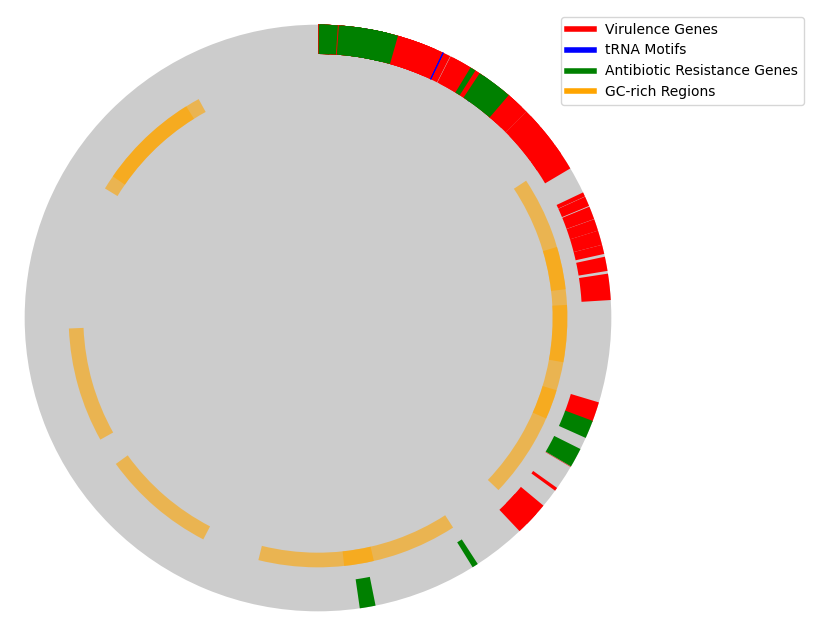

Potential PAI regions sorted by start position.
detected 1 clusters of potential PAIs.
filtering your clusters
Cluster skipped: Start=1, End=64132, Genes=124, tRNA_flanking=False, GC_overlap=False
total predicted PAIs: 0

Predicted Pathogenicity Islands:


In [5]:
if choice =="antibiotic":

  genes_file = input('Enter the resistance genes file:')  #"CARDgenes.fasta"
  database = input('Enter the reference dtabase:')        #"reference_db"
  results = input('Enter the name of the output file:')   #"blast_results.txt"
  do_blast(genes_file, database, results)

  gene_file_path = results
  strain_file_path = database
  output_file_path = "jaccard_distance_matrix.txt"

  strain_names = extract_strain_names(strain_file_path)

  presence_absence_matrix = initialize_presence_absence_matrix(gene_file_path, strain_names)
  presence_absence_matrix = fill_presence_absence_matrix(gene_file_path, presence_absence_matrix)

  print("Presence/Absence Matrix:")
  header = "\t" + "\t".join(strain_names)
  print(header)
  for gene, strains in presence_absence_matrix.items():
      row = f"{gene}\t" + "\t".join(str(strains[strain]) for strain in strain_names)
      print(row)

  jaccard_matrix, strains = calculate_distance_matrix(presence_absence_matrix, strain_names)

  print("\nJaccard Distance Matrix:")
  header = "\t" + "\t".join(strains)
  print(header)
  for i, row in enumerate(jaccard_matrix):
      formatted_row = "\t".join(f"{val:.4f}" for val in row)
      print(f"{strains[i]}\t{formatted_row}")

  save_jaccard_distance_matrix(jaccard_matrix, strains, output_file_path)

  most_occurring_gene, count = find_most_occurring_gene(presence_absence_matrix)
  print(f"\nMost Occurring Gene: {most_occurring_gene} (Present in {count} genomes)")

  filename = input('Enter the name of the file containing the distance matrix:')#"jaccard_distance_matrix (3)"
  n, dist_matrix = load_matrix(filename)
  nj = neighbor_joining(dist_matrix,n)
  see_tree(nj)
  print('If the branch length is 0, this means that the taxa or nodes share identical sequences or traits, and therefore, no genetic change or distance is observed between them.')



else:
  genome_file="MRSA-LUX10.fna"
  virulence_file= "VFDB_setA_nt.fasta"
  trna_file="trna-motifs.fasta"
  antibiotic_file="ANTI_resis.fasta"

  virulence_output="virulence_blast.txt"
  trna_output="trna_blast.txt"
  antibiotic_output="antibiotic_blast.txt"

  query_files=[virulence_file, trna_file, antibiotic_file]
  output_files=[virulence_output, trna_output, antibiotic_output]
  blast_alignments=[]
  alignment_categories=["Virulence Genes","tRNA Motifs","Antibiotic Resistance Genes"]

  categorized_alignments= {}
  for category in alignment_categories:
      categorized_alignments[category]= []
  for i in range(len(query_files)):
      query_file= query_files[i]
      output_file= output_files[i]
      category= alignment_categories[i]

      print("\nProcessing " + category)
      alignments = align_with_blast_and_filter(genome_file, [query_file], [output_file], identity_threshold=90)
      categorized_alignments[category].extend(alignments)

  print("\ndetecting regions with the highest GC content")
  genome_sequence = parsing(genome_file)
  top_gc_regions = detect_highest_gc_regions(genome_sequence, window_size=10000, top_n=10)

  print("\ntop 10 GC Content Regions:")
  for region in top_gc_regions:
      print("Start: " + str(region['start']) + ", End: " + str(region['end']) + ", GC Content: " + str(round(region['gc_content'], 2)) + "%")

  for category in categorized_alignments:
      print("\nfiltered " + category + ":")
      alignments = categorized_alignments[category]
      if len(alignments) > 0:
          for alignment in alignments:
              print("query: " + alignment["query_id"] + ", subject: " + alignment["subject_id"] + ", " + "identity: " + str(alignment["identity"]) + "%, Start: " + str(alignment["start"]) + ", End: " + str(alignment["end"]))
      else:
          print("No alignments found")

  genome_file="MRSA-LUX10.fna"
  genome= load_genome(genome_file)
  genome_length= len(genome)
  plot_circular_genome(genome_length, categorized_alignments, top_gc_regions)
  predicted_pais= detect_PAIs(genome_length, categorized_alignments, top_gc_regions)

  print("\nPredicted Pathogenicity Islands:")
  for pai in predicted_pais:
      gene_names= ""
      for gene in pai["genes"]:
          gene_names += gene + ", "
      gene_names= gene_names.strip(", ")

      print("Start: "+ str(pai["start"])+", End: "+ str(pai["end"])+", Genes: "+ gene_names +", GC Content: "+ str(pai["gc_content"]))